In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-15 15:07:36.491358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 15:07:36.557217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 15:07:36.559684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 15:07:37.516610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [2]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [4]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4409, 60)
(4409, 1)
(537, 60)
(537, 1)
(537, 60)
(537, 1)


In [5]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])

### Model 1: Baseline Model

Linear Regression:
</br> Input - Year and Urban Population
</br>Output - Avg Temp

In [6]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  year = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Year')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
    
  features = tf.keras.layers.Concatenate()([year, urban_pop])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[year, urban_pop],
                         outputs=temp,
                         name='Baseline')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Year (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['Year[0][0]',                
                                                                     'Urban Population[0][0]']    
                                                                                           

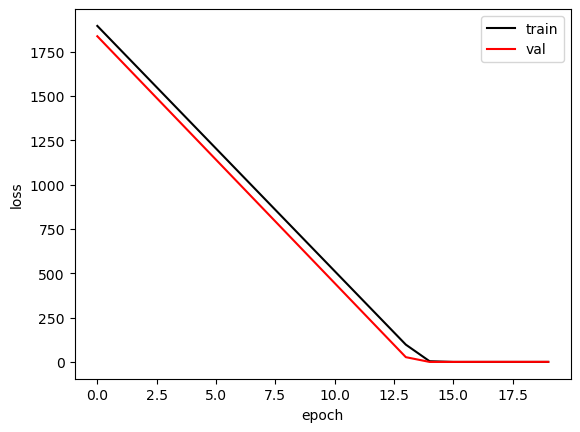

final train mae: 0.392
final val mae:   0.682


In [7]:
model = build_model()
model.summary()

history = model.fit(
  x={
      'Year': x_train[['year']],
      'Urban Population': x_train[['log_urban_population']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=64,
  validation_data=(
      {
      'Year': x_val[['year']],
      'Urban Population': x_val[['log_urban_population']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

In [43]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  year = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Year')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'East Asia', 'Melanesia','Micronesia', 'Wstern Europe', 
                                                           'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([year, urban_pop, sub_region_id])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[year, urban_pop, sub_region],
                         outputs=temp,
                         name='Model_2')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Year (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 string_lookup (StringLooku  (None, 20)                   0         ['Sub Region[0][0]']    

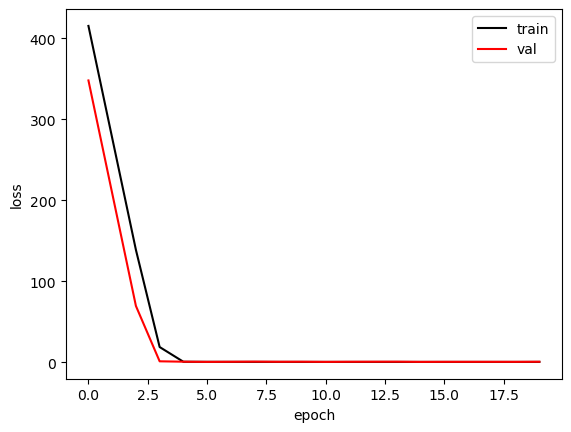

final train mae: 0.422
final val mae:   0.605


In [44]:
model = build_model()
model.summary()

history = model.fit(
  x={
      'Year': x_train[['year']],
      'Urban Population': x_train[['log_urban_population']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=64,
  validation_data=(
      {
      'Year': x_val[['year']],
      'Urban Population': x_val[['log_urban_population']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

In [41]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  year = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Year')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='10 Yr IPPU Total')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'East Asia', 'Melanesia','Micronesia', 'Wstern Europe', 
                                                           'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([year, urban_pop, sub_region_id,ippu_tot])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[year, urban_pop, sub_region, ippu_tot],
                         outputs=temp,
                         name='Model_3')
  
 
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Year (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 string_lookup (StringLooku  (None, 20)                   0         ['Sub Region[0][0]']    

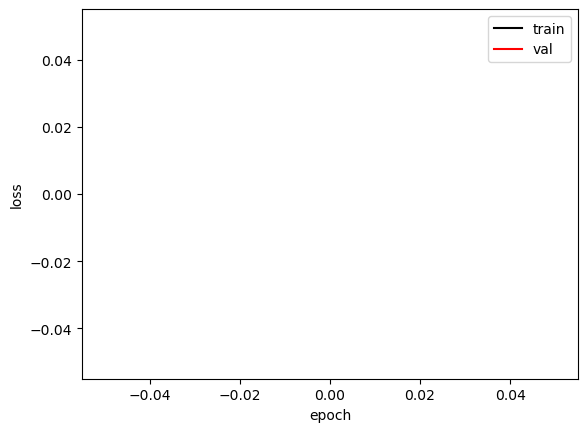

final train mae: nan
final val mae:   nan


In [42]:
model = build_model()
model.summary()

history = model.fit(
  x={
      'Year': x_train[['year']],
      'Urban Population': x_train[['log_urban_population']],
      'Sub Region': x_train[['sub-region']],
      '10 Yr IPPU Total': x_train[['10yr_log_ippu_tot']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=64,
  validation_data=(
      {
      'Year': x_val[['year']],
      'Urban Population': x_val[['log_urban_population']],
      'Sub Region': x_val[['sub-region']],
      '10 Yr IPPU Total': x_val[['10yr_log_ippu_tot']],
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)